<a href="https://colab.research.google.com/github/TAMIDSpiyalong/Machine-Learning-for-Computer-Vision/blob/main/Day2b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np
from torchvision import datasets, models, transforms
import torchvision
import matplotlib.pyplot as plt
import time
import os
import seaborn as sn
import pandas as pd
from torch.utils import data
import torch.nn as nn
import torch.optim as optim

In [2]:
# Some images are not stardard giving warnings, which is too much information.
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load the pretrained ResNet-18 model
resnet18 = models.resnet18(pretrained=False)

### ADDING THIS FOR DEBUGGING, TAKE IT OUT LATER
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Display the model summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet18.to(device)

# Use a sample input tensor to create the computation graph
sample_input = torch.randn((1, 3, 224, 224)).to(device)
# dot = make_dot(resnet18(sample_input), params=dict(resnet18.named_parameters()))

# Save the computation graph to a file (optional)
# dot.format = 'png'
# dot.render("resnet18_computation_graph")

In [4]:
# we have gpu on colab, but we have limited time access to it, you should be able to use the GPU for a few hours each week.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') #checking for and storing gpu
print(device)

cuda


## Prepare Image Data

### Image Transformation

In [5]:
# this is the mean and standard deviation for imagenet dataset
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

np.random.seed(50)  # new
transform = transforms.Compose([
#         transforms.RandomResizedCrop(224),
        transforms.Resize((224,224)),
#         transforms.CenterCrop((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

### Image Dataloader

In [6]:
images = datasets.ImageFolder('12k_imgs/imgs_organized', transform)

Show a subset of 5 images

In [7]:
images.imgs[194:200]

[('12k_imgs/imgs_organized/00/S00_FB_02_2023-09-02_NVRCH02-142741-143241_S1.0_7.jpg',
  0),
 ('12k_imgs/imgs_organized/00/S00_FB_02_2023-09-02_NVRCH02-142741-143241_S1.0_8.jpg',
  0),
 ('12k_imgs/imgs_organized/00/S00_FB_02_2023-09-02_NVRCH02-142741-143241_S1.0_9.jpg',
  0),
 ('12k_imgs/imgs_organized/00/S00_FB_02_2023-09-02_NVRCH02-142741-143241_S2.0_31.jpg',
  0),
 ('12k_imgs/imgs_organized/00/S00_FB_02_2023-09-03_NVRCH02-132005-132505_S1.0_1.jpg',
  0),
 ('12k_imgs/imgs_organized/00/S00_FB_02_2023-09-03_NVRCH02-132005-132505_S1.0_10.jpg',
  0)]

In [8]:
images.classes

['00', '05', '10', '20', '30', '40']

### Data Split for Training, Validation, and Testing

In [9]:
torch.manual_seed(50)  # necessary for cuda stuff i believe
# np.random_seed doesn't work for all pytorch stuff

data_size = len(images.imgs)
train_size = int(data_size*0.7)
val_size = (data_size-train_size)//2
test_size = data_size-train_size-val_size
train_set, val_set, test_set = data.random_split(images, (train_size,val_size,test_size))


In [10]:
train_size, val_size, test_size

(8513, 1824, 1825)

### Some quick verification for egleu

In [11]:
feedbunks = ['FB_01', 'FB_02', 'FB_03', 'FB_04', 'FB_05', 'FB_06']
cls_ = ['00', '05', '10', '20', '30', '40']
class_counts = {}

for fbk in feedbunks:
    for c in cls_:
        phrase = f'S{c}_{fbk}'
        egleu = f'{fbk}_S{c}'
        counter = 0
        for im in images.imgs:
            if phrase in im[0]:
                counter += 1
            class_counts[egleu] = counter

In [12]:
class_counts
# extras:
# fb_01_s05(1), fb_01_s20(2), fb_01_s30(1), fb_02_s30 (-31), fb_03_s10(6), FB_03_S30 (31), FB_04_S10 (-6), FB_04_S20 (1) 
# overall it comes out to be a difference of +5 which corresponds to the difference between my train set and the set egleu asked me to compare it to

{'FB_01_S00': 127,
 'FB_01_S05': 276,
 'FB_01_S10': 133,
 'FB_01_S20': 155,
 'FB_01_S30': 1038,
 'FB_01_S40': 0,
 'FB_02_S00': 126,
 'FB_02_S05': 449,
 'FB_02_S10': 87,
 'FB_02_S20': 142,
 'FB_02_S30': 188,
 'FB_02_S40': 75,
 'FB_03_S00': 198,
 'FB_03_S05': 381,
 'FB_03_S10': 1382,
 'FB_03_S20': 244,
 'FB_03_S30': 572,
 'FB_03_S40': 67,
 'FB_04_S00': 234,
 'FB_04_S05': 649,
 'FB_04_S10': 12,
 'FB_04_S20': 136,
 'FB_04_S30': 116,
 'FB_04_S40': 212,
 'FB_05_S00': 208,
 'FB_05_S05': 502,
 'FB_05_S10': 836,
 'FB_05_S20': 315,
 'FB_05_S30': 751,
 'FB_05_S40': 0,
 'FB_06_S00': 208,
 'FB_06_S05': 544,
 'FB_06_S10': 456,
 'FB_06_S20': 372,
 'FB_06_S30': 971,
 'FB_06_S40': 0}

In [13]:
cls_ = ['S00', 'S05', 'S10', 'S20', 'S30', 'S40']
counts = {}
bruhh = []
for c in cls_:
    cntr = 0
    for j in images.imgs:
        prefix = c#f'S{c}'
        if j[0][27:30] == prefix:
            cntr += 1
        else:
            bruhh.append(j[0])
    counts[prefix] = cntr
sum(counts.values())

12156

In [14]:
'12k_imgs/imgs_organized/05/.ipynb_checkpoints/S05_FB_01_2023-08-27_NVRCH02-093719-094219_S137.0_60-checkpoint.jpg'[46:]

'S05_FB_01_2023-08-27_NVRCH02-093719-094219_S137.0_60-checkpoint.jpg'

In [15]:
# 12k_imgs/imgs_organized/40/S40_FB_04_2023-08-05_NVRCH03-075844-080344_S85.0_145.jpg
anomalous = []
for i in images.imgs:
    if '.ipynb_checkpoints' in i[0]:
        anomalous.append(i[0])
        # anomalous.append(i[0][46:].replace('-checkpoint', ''))

# single = []
# for i in images.imgs:
#     single.append(i[0])
        
# for i in anomalous:
#     if i in single:
#         print('bruh')
anomalous

['12k_imgs/imgs_organized/05/.ipynb_checkpoints/S05_FB_01_2023-08-27_NVRCH02-093719-094219_S137.0_60-checkpoint.jpg',
 '12k_imgs/imgs_organized/20/.ipynb_checkpoints/S20_FB_01_2023-08-25_NVRCH02-101525-102025_S255.0_49-checkpoint.jpg',
 '12k_imgs/imgs_organized/20/.ipynb_checkpoints/S20_FB_01_2023-08-25_NVRCH02-102525-103025_S1.0_19-checkpoint.jpg',
 '12k_imgs/imgs_organized/20/.ipynb_checkpoints/S20_FB_04_2023-08-10_NVRCH03-074209-074709_S163.0_29-checkpoint.jpg',
 '12k_imgs/imgs_organized/30/.ipynb_checkpoints/S30_FB_01_2023-07-06_NVRCH02-101623-102123_S135.0_14-checkpoint.jpg',
 '12k_imgs/imgs_organized/30/.ipynb_checkpoints/S30_FB_01_2023-07-06_NVRCH02-101623-102123_S135.0_5-checkpoint.jpg']

In [16]:
i

('12k_imgs/imgs_organized/40/S40_FB_04_2023-08-05_NVRCH03-075844-080344_S85.0_145.jpg',
 5)

In [17]:
for i in images.imgs:
    # for j in cls_:
        # if j in i[0]:
    if i[0][27:30] not in cls_:
        print(i[0])

12k_imgs/imgs_organized/05/.ipynb_checkpoints/S05_FB_01_2023-08-27_NVRCH02-093719-094219_S137.0_60-checkpoint.jpg
12k_imgs/imgs_organized/20/.ipynb_checkpoints/S20_FB_01_2023-08-25_NVRCH02-101525-102025_S255.0_49-checkpoint.jpg
12k_imgs/imgs_organized/20/.ipynb_checkpoints/S20_FB_01_2023-08-25_NVRCH02-102525-103025_S1.0_19-checkpoint.jpg
12k_imgs/imgs_organized/20/.ipynb_checkpoints/S20_FB_04_2023-08-10_NVRCH03-074209-074709_S163.0_29-checkpoint.jpg
12k_imgs/imgs_organized/30/.ipynb_checkpoints/S30_FB_01_2023-07-06_NVRCH02-101623-102123_S135.0_14-checkpoint.jpg
12k_imgs/imgs_organized/30/.ipynb_checkpoints/S30_FB_01_2023-07-06_NVRCH02-101623-102123_S135.0_5-checkpoint.jpg


In [18]:
from torch.utils.data import DataLoader

batch_size=4
class_names = images.classes

train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=1)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=1)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=1)


### visualize the input examples

torch.Size([224, 224])
tensor([2, 3, 0, 4])


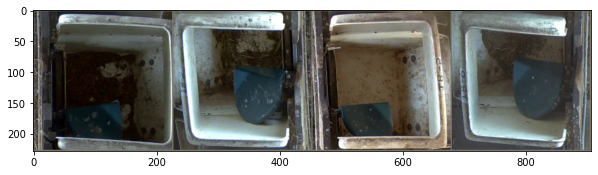

In [19]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean # correct the normalization
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)

# Get a batch of training data
inputs, classes = next(iter(train_dataloader))
print(inputs[0][0].shape)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
plt.figure(figsize=(10,5))
imshow(out, title='Input Examples')
print(classes)

## Train a Model without Pre-trained Weights

### Load Model and Modify

We can load the print out the model. We can also print each layer and see the parameters.

In [20]:
from torch.optim import lr_scheduler

# model = models.resnet18(pretrained=False)

# print(model.layer1)

In [21]:
# model.fc

In [22]:
# num_ftrs = model.fc.in_features
# # The last layer should have len(class_names neruons)
# model.fc = nn.Linear(num_ftrs, len(class_names))

In [23]:
# # model = model.to(device)

# criterion = nn.CrossEntropyLoss()

# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# # Decay LR by a factor of 0.1 every 5 epochs
# scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [24]:
# # for training a non-pretrained model!
# since = time.time()

# best_acc = 0.0
# num_epochs=10

# for epoch in range(num_epochs):
#     print('Epoch {}/{}'.format(epoch, num_epochs - 1))
#     print('-' * 10)

#     model.train()  # Set model to training mode
#     train_running_loss = 0.0
#     train_running_corrects = 0

#     for inputs, labels in train_dataloader:
#         inputs = inputs.to(device)
#         labels = labels.to(device)

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward
#         outputs = model(inputs)
#         _, preds = torch.max(outputs, 1)
#         loss = criterion(outputs, labels)

#         # backward + optimize only if in training phase
#         loss.backward()
#         optimizer.step()

#         # statistics
#         train_running_loss += loss.item() * inputs.size(0)
#         train_running_corrects += torch.sum(preds == labels.data)
#     scheduler.step()

#     train_epoch_loss = train_running_loss / len(train_set)
#     train_accuracy = train_running_corrects.double() / len(train_set)
#     print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_epoch_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")


#     # Each epoch has a validation phase

#     model.eval()   # Set model to evaluate mode
#     val_running_loss = 0.0
#     val_running_corrects = 0

#     # Iterate over data.
#     for inputs, labels in val_dataloader:
#         inputs = inputs.to(device)
#         labels = labels.to(device)

#         outputs = model(inputs)
#         _, preds = torch.max(outputs, 1)
#         loss = criterion(outputs, labels)

#         # statistics
#         val_running_loss += loss.item() * inputs.size(0)
#         val_running_corrects += torch.sum(preds == labels.data)

#     val_epoch_loss = val_running_loss / len(val_set)
#     val_accuracy = val_running_corrects.double() / len(val_set)
#     print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_epoch_loss:.4f}, validation Accuracy: {val_accuracy:.2f}%")

#         # deep copy the model
#     if  val_accuracy > best_acc:
#         best_acc = val_accuracy
#         best_model = model.state_dict()

# time_elapsed = time.time() - since
# print('Training complete in {:.0f}m {:.0f}s'.format(
#     time_elapsed // 60, time_elapsed % 60))
# print('Best val Acc: {:4f}'.format(best_acc))


In [25]:
# for inputs, labels in train_dataloader:
#     inputs = inputs.to(device)
#     labels = labels.to(device)

# print(inputs.size(),labels.size())

The model learns to some degree but the training and validation accuracy are pretty low. The visualization also shows that the model makes low confidence predictions.

### Result Visualization

In [26]:
def visualize_model(model, num_images=16):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(20,20))
    sm = torch.nn.Softmax()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_dataloader):
            inputs = inputs.to(device)
            l=labels
            labels = labels.to(device)
            model = model.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            confidence = np.amax(np.array(sm(outputs.cpu())),1)
#             break
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//4, 4, images_so_far)
                ax.set_xlabel('Groun Truth: {}'.format(class_names[l[j]]))
                ax.set_ylabel('Prediction: {}'.format(class_names[preds[j]]))
                ax.set_title('Confidence {:.2f}'.format(confidence[j]))

                inp = inputs.cpu().data[j].numpy().transpose((1, 2, 0))

                inp = std * inp + mean
                inp = np.clip(inp, 0, 1)
                ax.imshow(inp)
                if images_so_far == num_images:
                    return


In [27]:
# visualize_model(model)

## Train a Model with Pretrained Weights

This time we load the pretrained weight and see the difference. Everything else remains the same except `model = models.resnet18(pretrained=True)`.

In [28]:
class_names = ['S00','S05','S10','S20','S30','S40']

#### from torch.optim import lr_scheduler

model = models.resnet18(pretrained=True)

num_ftrs = model.fc.in_features
# The last layer should have len(class_names neruons)
model.fc = nn.Linear(num_ftrs, len(class_names))

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 5 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [91]:
# this trains the pretrained model on our data; not necessary to run unless you want to do that
since = time.time()

best_acc = 0.0
num_epochs=10

for epoch in range(num_epochs):
    print('\nEpoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    model.train()  # Set model to training mode
    train_running_loss = 0.0
    train_running_corrects = 0

    print('Checkpoint 1')
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # backward + optimize only if in training phase
        loss.backward()
        optimizer.step()

        # statistics
        train_running_loss += loss.item() * inputs.size(0)
        train_running_corrects += torch.sum(preds == labels.data)
    scheduler.step()
    print('internal checkpoint 2')
    train_epoch_loss = train_running_loss / len(train_set)
    train_accuracy = train_running_corrects.double() / len(train_set)
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_epoch_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")


    # Each epoch has a validation phase
    print('Checkpoint 2')
    model.eval()   # Set model to evaluate mode
    val_running_loss = 0.0
    val_running_corrects = 0

    # Iterate over data.
    for inputs, labels in val_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # statistics
        val_running_loss += loss.item() * inputs.size(0)
        val_running_corrects += torch.sum(preds == labels.data)
    
    print('Checkpoint 3')
    
    val_epoch_loss = val_running_loss / len(val_set)
    val_accuracy = val_running_corrects.double() / len(val_set)
    print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_epoch_loss:.4f}, validation Accuracy: {val_accuracy:.2f}%")

        # deep copy the model
    if  val_accuracy > best_acc:
        best_acc = val_accuracy
        best_model = model.state_dict()
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}'.format(best_acc))


Epoch 0/9
----------
Checkpoint 1
internal checkpoint 2
Epoch 1/10, Training Loss: 0.3360, Training Accuracy: 0.89%
Checkpoint 2
Checkpoint 3
Epoch 1/10, Validation Loss: 0.0241, validation Accuracy: 0.99%
Epoch 1/9
----------
Checkpoint 1
internal checkpoint 2
Epoch 2/10, Training Loss: 0.1051, Training Accuracy: 0.97%
Checkpoint 2
Checkpoint 3
Epoch 2/10, Validation Loss: 0.0246, validation Accuracy: 0.99%
Epoch 2/9
----------
Checkpoint 1
internal checkpoint 2
Epoch 3/10, Training Loss: 0.0538, Training Accuracy: 0.99%
Checkpoint 2
Checkpoint 3
Epoch 3/10, Validation Loss: 0.0046, validation Accuracy: 1.00%
Epoch 3/9
----------
Checkpoint 1
internal checkpoint 2
Epoch 4/10, Training Loss: 0.0369, Training Accuracy: 0.99%
Checkpoint 2
Checkpoint 3
Epoch 4/10, Validation Loss: 0.0079, validation Accuracy: 1.00%
Epoch 4/9
----------
Checkpoint 1
internal checkpoint 2
Epoch 5/10, Training Loss: 0.0300, Training Accuracy: 0.99%
Checkpoint 2
Checkpoint 3
Epoch 5/10, Validation Loss: 0.004

### Saving the Best Model and Load

In [29]:
# # !!!only run this cell if you want to save a new model!!!

# torch.save(best_model, 'best_model_used_for_jan_8th_abstract.pth')  # updated the name too so that it won't overwrite our old model

In [30]:
model = models.resnet18(pretrained=False)

num_ftrs = model.fc.in_features
# The last layer should have len(class_names neruons)
model.fc = nn.Linear(num_ftrs, len(class_names))

model.load_state_dict(torch.load('best_model_used_for_jan_8th_abstract.pth'))


<All keys matched successfully>

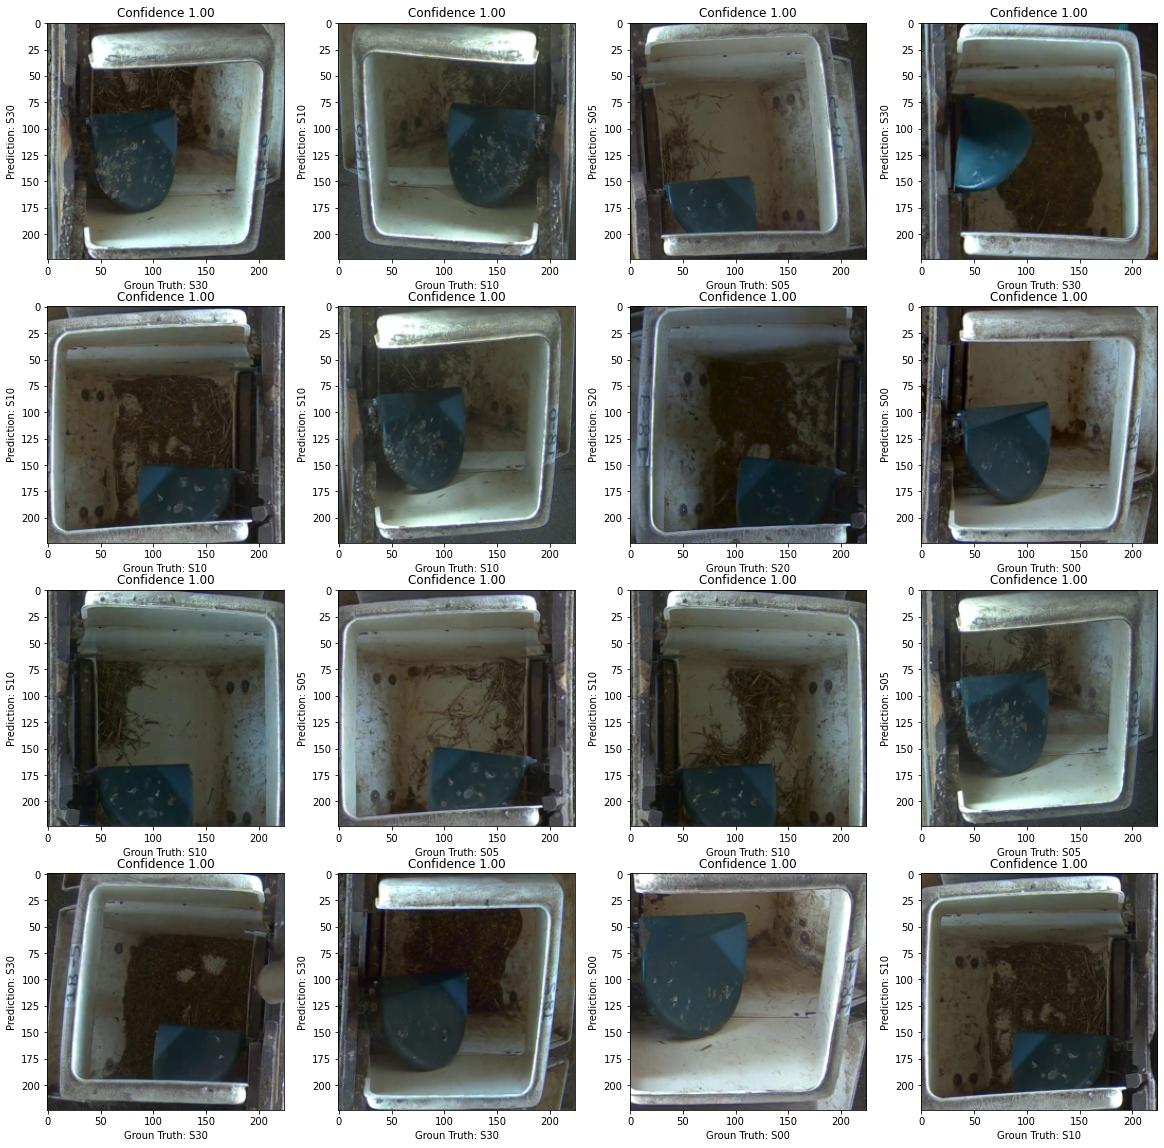

In [31]:
visualize_model(model)

## Output Format

In [32]:
# this is the mean and standard deviation for imagenet dataset
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

np.random.seed(50)  # new
transform = transforms.Compose([
#         transforms.RandomResizedCrop(224),
        transforms.Resize((224,224)),
#         transforms.CenterCrop((224,224)),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

This is a S30
[[2.7187954e-07 3.1615701e-07 4.9023009e-07 4.2320730e-07 9.9999607e-01
  2.4298429e-06]]


Text(0.5, 1.0, 'Confidence for each class')

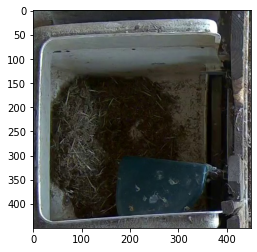

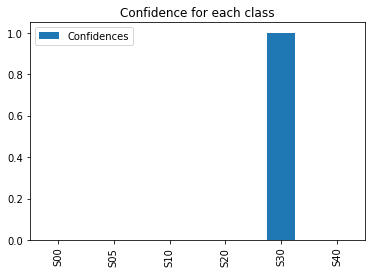

In [33]:
from PIL import Image

image = Image.open('12k_imgs/imgs_organized/30/S30_FB_03_2023-08-01_NVRCH03-083014-083142_S22.0_150.jpg')
plt.imshow(image)

x = transform(image)
x=x.to(device).unsqueeze(0) # Remove ".to(device)" if you experience RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

with torch.no_grad():
    model.eval()
    out = model(x)
    _, preds = torch.max(out, 1)

print('This is a {}'.format(class_names[preds]))
sm = torch.nn.Softmax()
confidences = np.array(sm(out.cpu()))
print(confidences)
df = pd.DataFrame({'Confidences':confidences[0]},index=class_names)
df.plot.bar()
plt.title('Confidence for each class')

## Confusion Matrix Result Analysis

In [34]:
nb_classes = len(class_names)
confusion_matrix = torch.zeros(nb_classes, nb_classes)
all_preds = []

with torch.no_grad():
    val_running_loss = 0.0
    val_running_corrects = 0
    for i, (inputs, classes) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for j in preds.cpu().numpy():
            all_preds.append(images.classes[j])
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[167.,   0.,   0.,   0.,   0.,   0.],
        [  0., 426.,   0.,   0.,   0.,   0.],
        [  0.,   0., 429.,   0.,   0.,   0.],
        [  0.,   0.,   0., 203.,   0.,   0.],
        [  0.,   0.,   0.,   0., 544.,   0.],
        [  0.,   0.,   0.,   0.,   0.,  56.]])


In [35]:
import re
all_labs = []
for i in images.imgs:
    all_labs.append(re.split('(ed\/[0-9]{2}\/)', i[0])[1][3:5])

test_labs = np.array(all_labs)[test_set.indices]  # ground truth labels

In [36]:
# all_preds == all_labs
dawg = 0  # just use this as a check to see if the length is the right size and there is a plausible match rate
for i in range(len(all_preds)):
    if all_preds[i] == test_labs[i]:
        dawg += 1
dawg

1825

In [37]:
correctly_classified = []
incorrectly_classified = []
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        if i==j:
            correctly_classified.append(confusion_matrix[i,j])
        # elif i != j and confusion_matrix[i,j] != 0:
        else:
            incorrectly_classified.append(confusion_matrix[i,j])
sum(incorrectly_classified) + sum(correctly_classified) == test_size

tensor(True)

In [38]:
for i in images.classes:
    if i in test_labs:
        count_ = sum(np.array(test_labs) == i)
        print(f'{count_} is the count for class: {i}')

167 is the count for class: 00
426 is the count for class: 05
429 is the count for class: 10
203 is the count for class: 20
544 is the count for class: 30
56 is the count for class: 40


In [39]:
df_cm = pd.DataFrame(confusion_matrix.numpy().astype('int'), index = [i for i in class_names],
                  columns = [i for i in class_names])

test_acc=np.trace(confusion_matrix.numpy().astype('int'))/np.sum(np.sum(df_cm))

# plt.figure(figsize = (len(class_names),len(class_names)))
# plt.title('Confusion Matrix with Testing Accuracy: {:0.2f}%'.format(test_acc*100))

# sn.heatmap(df_cm, annot=True,fmt='g',cmap="YlGnBu")
# plt.xlabel('True label')
# plt.ylabel('Predicted label')
# plt.savefig('ConfusionMatrixForEgleu.png', dpi=300)

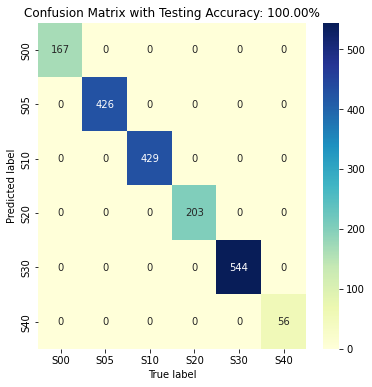

In [40]:
fig = plt.figure(figsize = (len(class_names),len(class_names)))
plt.title('Confusion Matrix with Testing Accuracy: {:0.2f}%'.format(test_acc*100))

sn.heatmap(df_cm, annot=True,fmt='g',cmap="YlGnBu")
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.savefig('ConfusionMatrixForEgleu.jpg', bbox_inches='tight', dpi=300)

## Get performance metrics

In [41]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
# precision, recall, accuracy, and f1-score
prec_all = precision_score(test_labs, all_preds, labels=images.classes, average='weighted')
rec_all = recall_score(test_labs, all_preds, labels=images.classes, average='weighted')
# acc = accuracy_score(test_labs, all_preds)
f1_all = f1_score(test_labs, all_preds, labels=images.classes, average='weighted')

In [42]:
overall_metrics_df = pd.DataFrame({'prec_all':prec_all,
'rec_all':rec_all,
'f1_all':f1_all}, index=images.classes)
overall_metrics_df

,prec_all,rec_all,f1_all
00,1.0,1.0,1.0
05,1.0,1.0,1.0
10,1.0,1.0,1.0
20,1.0,1.0,1.0
30,1.0,1.0,1.0
40,1.0,1.0,1.0


In [43]:
prec_classwise = precision_score(test_labs, all_preds, labels=images.classes, average=None)
rec_classwise = recall_score(test_labs, all_preds, labels=images.classes, average=None)
f1_classwise = f1_score(test_labs, all_preds, labels=images.classes, average=None)

In [44]:
metrics_dataframe = pd.DataFrame({'prec_classwise': prec_classwise, 
              'rec_classwise': rec_classwise, 
              'f1_classwise': f1_classwise}, index=images.classes)
metrics_dataframe

,prec_classwise,rec_classwise,f1_classwise
00,1.0,1.0,1.0
05,1.0,1.0,1.0
10,1.0,1.0,1.0
20,1.0,1.0,1.0
30,1.0,1.0,1.0
40,1.0,1.0,1.0
